# IBM Data Science Specialization
# Applied Data Science Capstone

## Captstone Project: The Battle of the Neighbourhoods
### Student: 
Juan Ignacio Morales Volosín

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Discussion and Conclusion](#discussion)

## Introduction <a name="introduction"></a>

### Problem Description
**This project is a preliminary study about establishing the better location to open a new restaurant in Buenos Aires, Argentina**. To accomplish this, the city will be devided into its traditional neighbourhoods. 
As a first criterion in the selection, competition should be taken into consideration. Accordinlgy, the neighbourhoods presenting a lower amount of restaurants will be preferred.

As a second criterion, potential attendance is of interest. In this case, neighbourhoods with a bigger population will have an advantage. However, there is also the factor of public transportation, which helps in letting people living further from a neighbourhood to potentially travel to it and eat at a restaurant there.
**The question is, therefore, which neighbourhood has less restaurants, is more populated and better connected? Its answer is crucial for entrepreneurs in the field of gastronomy**.

### Background
The Autonomous City of Buenos Aires (or simply Buenos Aires) is the capital city of Argentine and also the largest one in this country. This is in the South American continent, with the city placed on the western shore of the estuary Río de la Plata. It is included in the Greater Buenos Aires, which comprises an urban conglomeration with the fourth biggest population in the Americas. The city is an autonomous district, not being a part of the province of the same name which surrounds it by land. Internally, Buenos Aires is subdivided in communes, that serve some administrative purposes and, at the same time, it is traditionally divided in fourty-eight neighbourhoods.
Presenting one of the highest living qualities in South America, a numerous population and brimming with tourism, this multicultural city offers an attractive prospect to anyone interested in the gastronomical business. 

## Data <a name="data"></a>

### Description
#### Foursquare
Its API will be used to obtain data related to the first criterion in the selection of a neighbourhood to open a restaurant. It will be fed the coordinates of each neighbourhood, returning a json file. From it the relevant information will be extracted, presenting mainly venues, their categories and their coordinates.

#### ArcGIS
Their API will also be used, feeding it with the name of a location in order to obtain its geographical coordinates. In this study in particular, it will be used mainly to get the coordinates of Buenos Aires and all its neighbourhoods.

#### Buenos Aires – Datasets
Additionally to the already mentioned sources, datasets provided by the government of the City of Buenos Aires.
##### Neighbourhoods
https://data.buenosaires.gob.ar/dataset/barrios/archivo/juqdkmgo-191-resource (in Spanish).
##### Population
https://data.buenosaires.gob.ar/dataset/estructura-demografica/archivo/c44be985-8d7f-4aa4-972e-a7f8f0b796dc (in Spanish).
##### Bus Stops
https://data.buenosaires.gob.ar/dataset/colectivos-gtfs (in Spanish).
##### Train Stations
https://data.buenosaires.gob.ar/dataset/estaciones-ferrocarril/archivo/juqdkmgo-1021-resource (in Spanish).
##### Subway Stations
https://data.buenosaires.gob.ar/dataset/subte-estaciones/archivo/juqdkmgo-1992-resource (in Spanish).
##### Tram Stations
https://data.buenosaires.gob.ar/dataset/premetro/archivo/juqdkmgo-1651-resource (in Spanish).

### Usage
The starting point will be the Neighbourhood dataset, because after some preparation of this set, the names of the neighbourhoods will be fed to the ArcGIS API in order to obtain the coordinates of each of them. These coordinates will be appended to this dataset.

The datasets Bus Stops, Train Stations, Subway Stations and Tram Stations will be cleaned and prepared with the aim of obtaining only the geographical coordinates of each stop/station reported in them. Later, using these datasets and the field WKT of the Neighbourhood ones, each stop/station will be assigned to a neighbourhood. Consequently, all stops/stations outside of the limits of the City of Buenos Aires will be dropped. Finally, each of these datasets related to the public transportation system will be turned into dataframes counting how many stops/stations there are in each neighbourhood.

Finally, all the dataframes will be combined in a single dataframe in which each row will represent a neighbourhood containing all the prepared information described up to this point and allowing the analysis which ultimately will help answer the question stated in the initial parts of this study.

Installation of the necessary packages.

In [3]:
!conda install -c conda-forge geopy --yes
!pip install geocoder
!pip install shapely
print("Installed!")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Installed!


Importation of needed libraries and functions.

In [4]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import geocoder
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.wkt
import folium
import json
from geopy.geocoders import Nominatim
import requests
import matplotlib as mpl
import matplotlib.cm as cm                          
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from collections import Counter
print('Imported!')

Imported!


## Processing of the geographical information about neighbourhoods

Loading of the dataset for the neighbourhoods in Buenos Aires. It can be found in the URL:
http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios

In [5]:
CABAbarrios = pd.read_csv('09.17 - barrios.csv')
CABAbarrios.head()

WKT            barrio  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         CHACARITA   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          PATERNAL   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      VILLA CRESPO   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  VILLA DEL PARQUE   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           ALMAGRO   

   comuna    perimetro          area  
0      15  7724.852955  3.115707e+06  
1      15  7087.513295  2.229829e+06  
2      15  8131.857075  3.615978e+06  
3      11  7705.389797  3.399596e+06  
4       5  8537.901368  4.050752e+06

Renaming of the columns to make them understandable in English, and dropping the unnecesary ones. Also, unit conversion will be performed, in order that 'Area' reads in square kilometers. Additionally, the names of the neighbourhoods will be formatted to uppercase only in the first letter of each word.

In [6]:
CABAbarrios.drop(columns = ['comuna', 'perimetro'], inplace = True)
CABAbarrios.rename(columns={'barrio':'Neighbourhood', 'area':'Area'}, inplace = True)
CABAbarrios['Area'] = CABAbarrios['Area']/1000000
CABAbarrios.Neighbourhood = CABAbarrios.Neighbourhood.str.title()
CABAbarrios.head()

WKT     Neighbourhood  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         Chacarita   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          Paternal   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      Villa Crespo   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  Villa Del Parque   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           Almagro   

       Area  
0  3.115707  
1  2.229829  
2  3.615978  
3  3.399596  
4  4.050752

Extraction of the coordinates for each neighbourhood. 'Latitude' and 'Longitude' will read in degrees, and will be shown in the decimal format.

In [7]:
latitude=[]
longitude=[]
for nghbhd in CABAbarrios['Neighbourhood']:
    g = geocoder.arcgis('{}, Ciudad Autonoma de Buenos Aires, Argentina'.format(nghbhd))
    print(nghbhd, g.latlng)
    while (g.latlng is None):
        g = geocoder.arcgis('{}, Ciudad Autonoma de Buenos Aires, Argentina'.format(nghbhd))
        print(nghbhd, g.latlng)
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])

Chacarita [-34.58350999999993, -58.45286999999996]
Paternal [-34.59541999999993, -58.471559999999954]
Villa Crespo [-34.59668999999997, -58.442249999999945]
Villa Del Parque [-34.60271999999998, -58.48886999999996]
Almagro [-34.60323999999997, -58.42042999999995]
Caballito [-34.62261999999998, -58.44621999999998]
Villa Santa Rita [-34.61391999999995, -58.479439999999954]
Monte Castro [-34.61952999999994, -58.505349999999964]
Villa Real [-34.620589999999936, -58.52843999999993]
Flores [-34.62871999999993, -58.461919999999964]
Floresta [-34.62891999999994, -58.48133999999993]
Constitucion [-34.62120999999996, -58.38654999999994]
San Cristobal [-34.62369999999993, -58.40148999999997]
Boedo [-34.63203999999996, -58.41777999999994]
Velez Sarsfield [-34.63122999999996, -58.49267999999995]
Villa Luro [-34.637449999999944, -58.49965999999995]
Parque Patricios [-34.636199999999974, -58.400679999999966]
Mataderos [-34.657479999999964, -58.498969999999986]
Villa Lugano [-34.672639999999944, -58.4

Appending of the coordinates to the existing dataframe.

In [8]:
CABAbarrios['Latitude'] = latitude
CABAbarrios['Longitude'] = longitude
CABAbarrios.head()

WKT     Neighbourhood  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         Chacarita   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          Paternal   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      Villa Crespo   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  Villa Del Parque   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           Almagro   

       Area  Latitude  Longitude  
0  3.115707 -34.58351  -58.45287  
1  2.229829 -34.59542  -58.47156  
2  3.615978 -34.59669  -58.44225  
3  3.399596 -34.60272  -58.48887  
4  4.050752 -34.60324  -58.42043

When the coordinates were obtained, it could be noted by visual inspection some latitudes that did not begin with the same integer as the rest. Following, the evidencing of this issue.

In [9]:
display(CABAbarrios.loc[CABAbarrios['Neighbourhood'].isin(['Belgrano', 'Saavedra', 'San Nicolas'])])

WKT Neighbourhood      Area  \
20  POLYGON ((-58.4881310699952 -34.5612869279226,...      Saavedra  5.538677   
42  POLYGON ((-58.3679211193597 -34.6051742887552,...   San Nicolas  2.289008   
43  POLYGON ((-58.4505669109009 -34.5356104340406,...      Belgrano  7.999240   

     Latitude  Longitude  
20 -37.761340  -62.35293  
42 -33.486428  -60.29506  
43 -35.766030  -58.49758

Those latitudes do not correspond to the City of Buenos Aires. The issue is due to the Arcgis API associating the name of those neighbourhoods to other locations, not in the City, but in the Province of Buenos Aires, which limits with the City in its land perimeter. This will be corrected by hand, obtaining the correct coordinates from the search engine in the «Mapa Interactivo de Buenos Aires v4.1.2» (Interactive Map of Buenos Aires v4.1.2), which can be visited in this URL:
https://mapa.buenosaires.gob.ar/buscador/

In [10]:
CABAbarrios.loc[CABAbarrios.Neighbourhood == 'Belgrano', ['Latitude', 'Longitude']] = [-34.554763, -58.450241]
CABAbarrios.loc[CABAbarrios.Neighbourhood == 'Saavedra', ['Latitude', 'Longitude']] = [-34.553077, -58.488743]
CABAbarrios.loc[CABAbarrios.Neighbourhood == 'San Nicolas', ['Latitude', 'Longitude']] = [-34.603665, -58.380519]

The corroboration showing the coordinates were correctly entered:

In [11]:
display(CABAbarrios.loc[CABAbarrios['Neighbourhood'].isin(['Belgrano', 'Saavedra', 'San Nicolas'])])

WKT Neighbourhood      Area  \
20  POLYGON ((-58.4881310699952 -34.5612869279226,...      Saavedra  5.538677   
42  POLYGON ((-58.3679211193597 -34.6051742887552,...   San Nicolas  2.289008   
43  POLYGON ((-58.4505669109009 -34.5356104340406,...      Belgrano  7.999240   

     Latitude  Longitude  
20 -34.553077 -58.488743  
42 -34.603665 -58.380519  
43 -34.554763 -58.450241

The 'WKT' column contains the shape of each neighbourhood and can be read as a Polygon object by the Shapely library. This will be used for a little verification: that the obtained coordinates are indeed inside of the neighbourhood they should be.

In [12]:
# This will build a list of lists. Each nested list will contain the result of the 
# check (True/False) and the index of the neighbourhood.
verification = []
for i in range(len(CABAbarrios['WKT'])):
    pto = Point(CABAbarrios.loc[i,'Longitude'], CABAbarrios.loc[i,'Latitude'])
    poli = shapely.wkt.loads(CABAbarrios.loc[i,'WKT'])
    verif = pto.within(poli)
    verification.append([verif, i])

In [13]:
# This will confirm that all "verif" boolean objects are True.
all(flag == True for (flag, _) in verification)

True

Continuing, to see where we arrived in processing the initial data: display of the first rows, the shape and the data types of the dataframe.

In [14]:
display(CABAbarrios.head())
print('The shape of this dataframe is: ', CABAbarrios.shape)
CABAbarrios.dtypes

WKT     Neighbourhood  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         Chacarita   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          Paternal   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      Villa Crespo   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  Villa Del Parque   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           Almagro   

       Area  Latitude  Longitude  
0  3.115707 -34.58351  -58.45287  
1  2.229829 -34.59542  -58.47156  
2  3.615978 -34.59669  -58.44225  
3  3.399596 -34.60272  -58.48887  
4  4.050752 -34.60324  -58.42043

The shape of this dataframe is:  (48, 5)


WKT               object
Neighbourhood     object
Area             float64
Latitude         float64
Longitude        float64
dtype: object

A first visualization of Buenos Aires, its neighbourhoods and the retrieved coordinates will be created, to start becoming familiar with the study case.

Obtention of the coordinates of the City of Buenos Aires.

In [15]:
g = geocoder.arcgis('Ciudad Autónoma de Buenos Aires, Argentina')
while (g.latlng is None):
    g = geocoder.arcgis('Ciudad Autonoma de Buenos Aires, Argentina')
print('Done.')

Done.


The dataset provided in csv file that was used to work so far is also provided in geojson format, in the same URL:
http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios

This is useful for a fast visualization, as follows.

In [16]:
CABAgeo = r'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson'

In [17]:
# Creation of the map
CABAmap = folium.Map(location=[g.latlng[0], g.latlng[1]], zoom_start=11)
CABAmap.choropleth(
    geo_data=CABAgeo,
    data=pd.concat([pd.DataFrame(CABAbarrios.Neighbourhood.str.upper()), CABAbarrios.loc[:, 'Area']], axis=1, ignore_index=True).rename(columns = {0:'Neighbourhood', 1:'Area'}),
    columns=['Neighbourhood', 'Area'],
    key_on='feature.properties.barrio',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Area in km^2 by Neighborhood in Buenos Aires'
)

In [18]:
# Addition of markers to the map.
for nghbhd, lat, lng in zip(
    CABAbarrios['Neighbourhood'], 
    CABAbarrios['Latitude'], 
    CABAbarrios['Longitude']):
        label = '{}'.format(nghbhd)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=4,
            popup=label,
            color='green',
            fill=False,
            #fill_color='#ffae1a',
            #fill_opacity=0.3,
            parse_html=False).add_to(CABAmap)

In [19]:
# display map
CABAmap

That is Buenos Aires and its neighbourhoods, coloured accordingly to their size. All the land surrounding the City is the Province of Buenos Aires. The water is an estuary, often confused with a river, because of its name: "Río de la Plata" (River of Silver).

## Processing of the information about population in Buenos Aires

This dataset simply provides the population sorted by neighbourhood. It can be found in the following link:

https://data.buenosaires.gob.ar/dataset/estructura-demografica/archivo/c44be985-8d7f-4aa4-972e-a7f8f0b796dc

In [20]:
popuNeigh = pd.read_csv('09.17 - CABA - caba_pob_barrios_2010.csv')
print('The shape of popuNeigh is: ', popuNeigh.shape)
popuNeigh.head()

The shape of popuNeigh is:  (48, 2)


BARRIO  POBLACION
0  AGRONOMIA      13912
1    ALMAGRO     131699
2  BALVANERA     138926
3   BARRACAS      89452
4   BELGRANO     126267

This dataset is essentially exactly what it is needed for this study. Only minor details will be modified to bring it to the same standard as the rest.

In [21]:
popuNeigh.columns = ['Neighbourhood', 'Population']
popuNeigh.Neighbourhood = popuNeigh.Neighbourhood.str.title()
popuNeigh.head()

Neighbourhood  Population
0     Agronomia       13912
1       Almagro      131699
2     Balvanera      138926
3      Barracas       89452
4      Belgrano      126267

A similar map will be created to start understanding the distribution of the population in Buenos Aires.

In [22]:
# Creation of the map
CABApmap = folium.Map(location=[g.latlng[0], g.latlng[1]], zoom_start=12)
CABApmap.choropleth(
    geo_data=CABAgeo,
    data=pd.concat([pd.DataFrame(popuNeigh.Neighbourhood.str.upper()), popuNeigh.loc[:, 'Population']], axis=1, ignore_index=True).rename(columns = {0:'Neighbourhood', 1:'Population'}),
    columns=['Neighbourhood', 'Population'],
    key_on='feature.properties.barrio',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population by Neighborhood in Buenos Aires'
)

In [23]:
# Display of the map
CABApmap

This looks satisfactory enough to further continue with the study. More specifically, from now on the information about public transportation will be processed.

## Processing of the information about bus stops in Buenos Aires

This dataset includes a number of files compressed in a .zip file. The one of interest for this study is “stops.txt”, which internally is actually a .csv file. It must be noticed that the listed stops belong not only to the City of Buenos Aires, but also to Buenos Aires Province.  It can be found in the following link:

https://data.buenosaires.gob.ar/dataset/colectivos-gtfs

In [24]:
busStop = pd.read_csv('09.17 - CABA - bus-stops.csv')
busStop.head()

stop_id   stop_code                        stop_name   stop_lat  \
0   691100952   691100952      AVENIDA EVA PERÓN 1249-1299 -34.797232   
1   628117050   628117050            20 DE SEPTIEMBRE 1787 -34.796415   
2  6490106165  6490106165  AVENIDA HIPÓLITO YRIGOYEN 12036 -34.795890   
3   691134825   691134825                    CALLE 55 5212 -34.794890   
4  6427126626  6427126626                 B. MAGAN 300-498 -34.794052   

    stop_lon  
0 -58.232208  
1 -58.359195  
2 -58.408950  
3 -58.168118  
4 -58.615190

In [25]:
busStop.shape

(43594, 5)

At first glance, it is possible to see there is a really big number of bus stops. This could indicate that not all of them belong to the City of Buenos Aires, but probably both to it and the Province.

Unrelated to that, the only columns of interest for this study are those with the coordinates. Therefore, all other columns will be dropped. The remaining ones repositioned and renamed.

In [26]:
busStop.drop(columns = ['stop_code', 'stop_name', 'stop_id'], inplace = True)
fixed_columns = [busStop.columns[1]] + \
                [busStop.columns[0]]
busStop = busStop[fixed_columns]
busStop.rename(columns={'stop_lon':'Bus_Long', 'stop_lat':'Bus_Lati'}, inplace = True)
print(busStop.shape)
busStop.head()

(43594, 2)


Bus_Long   Bus_Lati
0 -58.232208 -34.797232
1 -58.359195 -34.796415
2 -58.408950 -34.795890
3 -58.168118 -34.794890
4 -58.615190 -34.794052

Each bus stop will be assigned to a neighbourhood.

The following code will create a Shapely polygon object with each neighbourhood. Then, it will create a Shapely Point object with the coordinates of each bus stop. It will do a check, to see if the point is inside that polygon or neighbourhood. When it finds a point that fullfils that condition, it will create a list containing the index corresponding to that point in the busStop dataframe and the name of the neighbourhood of which it is inside. This list will finally be appended to the indxNeigh list.

In [27]:
indxNeigh = []
for i in range(len(CABAbarrios['WKT'])):
    poly = shapely.wkt.loads(CABAbarrios.loc[i, 'WKT'])
    for j in range(len(busStop['Bus_Long'])):
        pnt = Point(busStop.loc[j, 'Bus_Long'], busStop.loc[j, 'Bus_Lati'])
        if pnt.within(poly) == True:
            indxNeigh.append([j, CABAbarrios.loc[i, 'Neighbourhood']])

Create a dataframe using the indxNeigh list.

In [28]:
indStops = pd.DataFrame(indxNeigh, columns = ['bStopIndex', 'Neighbourhood'])
print('Shape of indStops is: ', indStops.shape)
indStops.head()

Shape of indStops is:  (8321, 2)


bStopIndex Neighbourhood
0       12083     Chacarita
1       13908     Chacarita
2       14131     Chacarita
3       14939     Chacarita
4       14945     Chacarita

Confirm all indices are unique:

In [29]:
len(indStops['bStopIndex'].unique())

8321

This means, there are 'only' 8321 bus stops in City of Buenos Aires, the remaining ones are in Buenos Aires Province.

In [30]:
len(indStops['Neighbourhood'].unique())

48

This confirms there are bus stops in all the 48 neighbourhoods of the City of Buenos Aires.

Now, a third column will be added to the busStop dataframe. Later, the names of the neighbourhood to which each bus stop corresponds will be added.

In [31]:
busStop['Neighbourhood'] = np.nan
busStop.head()

Bus_Long   Bus_Lati  Neighbourhood
0 -58.232208 -34.797232            NaN
1 -58.359195 -34.796415            NaN
2 -58.408950 -34.795890            NaN
3 -58.168118 -34.794890            NaN
4 -58.615190 -34.794052            NaN

In the following code, assignment is carried out of a neighbourhood to each pair of coordinates corresponding to each bus stop.

In [32]:
for i in range(len(indStops['bStopIndex'])):
    j = indStops.loc[i, 'bStopIndex']
    busStop.loc[j, 'Neighbourhood'] = indStops.loc[i, 'Neighbourhood']

A check will be done, to see if all neighbourhoods were assigned to the coordinates. The number of unique elements should be 48 for each of the neighbourhoods and 1 for the np.nan values.

In [33]:
print('Unique values in column Neighbourhood: ', len(busStop['Neighbourhood'].unique()))
print('Shape of busStop: ', busStop.shape)

Unique values in column Neighbourhood:  49
Shape of busStop:  (43594, 3)


At this point, the busStop dataframe still contains the coordinates of the bus stops that are in the Province of Buenos Aires, while the interest is in those that are in the City. The ones in the Province would still have the np.nan values in the Neighbourhood column, and these will be used to drop the rows corresponding to those bus stops.

In [34]:
busStop.dropna(subset = ['Neighbourhood'], inplace = True)
busStop.reset_index(drop = True, inplace = True)

Confimation through shape and visualizing the dataframe first rows.

In [35]:
print('busStop shape: ', busStop.shape)
busStop.head()

busStop shape:  (8321, 3)


Bus_Long   Bus_Lati    Neighbourhood
0 -58.466500 -34.694725  Villa Riachuelo
1 -58.471268 -34.697825  Villa Riachuelo
2 -58.475287 -34.693920  Villa Riachuelo
3 -58.475732 -34.677645     Villa Lugano
4 -58.466370 -34.700668  Villa Riachuelo

Finally, a new dataframe will be created the neighbourhoods of the City of Buenos Aires, showing how many bus stops it has. This is the information of interest for the study.

In [36]:
busStNeigh = busStop.groupby('Neighbourhood', as_index = False)['Neighbourhood'].agg({'Count': 'count'})
print('The shape of busStNeigh is: ', busStNeigh.shape)
busStNeigh.head()

The shape of busStNeigh is:  (48, 2)


Neighbourhood  Count
0     Agronomia     35
1       Almagro    265
2     Balvanera    392
3      Barracas    284
4      Belgrano    248

This looks satisfactory enough to further continue with the project.

## Processing of the information about train stations in Buenos Aires

As in the previous case, in this dataset, the stations belong to both the City and the Province. It can be found in the following link:

https://data.buenosaires.gob.ar/dataset/estaciones-ferrocarril/archivo/juqdkmgo-1021-resource

In [37]:
trainSta = pd.read_csv('09.17 - CABA - estaciones-de-ferrocarril.csv')
print(trainSta.shape)
trainSta.head()

(230, 11)


long        lat   id          nombre  linea     linea_2  \
0 -58.424982 -34.571748    1    3 de Febrero  Mitre  F.C.G.B.M.   
1 -58.461808 -34.568051   35      Belgrano R  Mitre  F.C.G.B.M.   
2 -58.475348 -34.565261   90         Coghlan  Mitre  F.C.G.B.M.   
3 -58.448253 -34.572975   91      Colegiales  Mitre  F.C.G.B.M.   
4 -58.494130 -34.523089  119  Dr. Cetrángolo  Mitre  F.C.G.B.M.   

             ramal      barrio     comuna localidad             partido  
0   Retiro - Mitre     Palermo  Comuna 14       NaN                 NaN  
1   Retiro - Mitre    Belgrano  Comuna 13       NaN                 NaN  
2   Retiro - Mitre     Coghlan  Comuna 12       NaN                 NaN  
3   Retiro - Mitre  Colegiales  Comuna 13       NaN                 NaN  
4   Retiro - Mitre         NaN        NaN   Florida  Vicente L\u00f3pez

It is possible to notice this dataset presents information of train stations, not only in the City of Buenos Aires, but also in the Province. Knowing local uses, it is possible to infer that "barrio" (neighbourhood) and "comuna" (commune) belong to the City, while "localidad" (town) and "partido" (municipality) belong to the Province. These being mutually exclusive will help in cleaning the data set, allowing to drop rows with NaN values in the "barrio" column. This will be the first step. Then, because of relevance for the study, all columns will be dropped, except for "long", "lat" and "barrio". These will be renamed.

In [38]:
trainSta.dropna(subset = ['barrio'], inplace = True)
trainSta.drop(columns = ['id', 'nombre', 'linea', 'linea_2', 'ramal', 'comuna', 'localidad', 'partido'], inplace = True)
trainSta.rename(columns={'long':'Train_Long', 'lat':'Train_Lati', 'barrio':'Neighbourhood'}, inplace = True)
print(trainSta.shape)
trainSta.head()

(29, 3)


Train_Long  Train_Lati Neighbourhood
0  -58.424982  -34.571748       Palermo
1  -58.461808  -34.568051      Belgrano
2  -58.475348  -34.565261       Coghlan
3  -58.448253  -34.572975    Colegiales
7  -58.435404  -34.575705       Palermo

Considering that each pair of coordinates corresponding to a train station is already assigned to a neighbourhood in the City of Buenos Aires, the only thing left to do is count how many there are in each of those neighbourhoods. A new dataframe is created to this end.

In [39]:
trainStNeigh = trainSta.groupby('Neighbourhood', as_index = False)['Neighbourhood'].agg({'Count': 'count'})
print('The shape of trainStNeigh is: ', trainStNeigh.shape)
trainStNeigh.head()

The shape of trainStNeigh is:  (22, 2)


Neighbourhood  Count
0     Balvanera      1
1      Barracas      1
2      Belgrano      2
3     Caballito      1
4       Coghlan      1

This looks satisfactory enough to further continue with the project.

## Processing of the information about subway stations in Buenos Aires

This is the dataset about subway stations and can be found in the following link:

https://data.buenosaires.gob.ar/dataset/subte-estaciones/archivo/juqdkmgo-1992-resource

In [40]:
subSta = pd.read_csv('09.17 - CABA - estaciones-accesibles.csv')
print('The shape of subSta is: ', subSta.shape)
subSta.head()

The shape of subSta is:  (93, 6)


long        lat linea       estacion  escaleras_mecanicas  ascensores
0 -58.436429 -34.618280     A         ACOYTE                    2           2
1 -58.456710 -34.626667     A       CARABOBO                    3           3
2 -58.421816 -34.611770     A  CASTRO BARROS                    1           1
3 -58.392669 -34.609226     A       CONGRESO                    2           2
4 -58.382232 -34.609100     A           LIMA                    1           0

This dataset, without a doubt, contains only information of subway stations in the City of Buenos Aires, as it is the only place in Argentina where such a transportation means exist.

From visual inspection, it is possible to infer that "long" and "lat" are the geographical coordinates of each subway station, and this is the only relevant information for the study. Every other column will be dropped, and the remaining ones renamed.

In [41]:
subSta.drop(columns = ['linea', 'estacion', 'escaleras_mecanicas', 'ascensores'], inplace = True)
subSta.rename(columns={'long':'Sub_Long', 'lat':'Sub_Lati'}, inplace = True)
print(subSta.shape)
subSta.head()

(93, 2)


Sub_Long   Sub_Lati
0 -58.436429 -34.618280
1 -58.456710 -34.626667
2 -58.421816 -34.611770
3 -58.392669 -34.609226
4 -58.382232 -34.609100

The following code will create a Shapely polygon object with each neighbourhood. Then, it will create a Shapely Point object with the coordinates of each subway station. It will do a check, to see if the point is inside that polygon or neighbourhood. When it finds a point that fullfils that condition, it will create a list containing the index corresponding to that point in the subSta dataframe and the name of the neighbourhood of which it is inside. This list will finally be appended to the indxNeigh list.

In [42]:
indxNeigh = []
for i in range(len(CABAbarrios['WKT'])):
    poly = shapely.wkt.loads(CABAbarrios.loc[i, 'WKT'])
    for j in range(len(subSta['Sub_Long'])):
        pnt = Point(subSta.loc[j, 'Sub_Long'], subSta.loc[j, 'Sub_Lati'])
        if pnt.within(poly) == True:
            indxNeigh.append([j, CABAbarrios.loc[i, 'Neighbourhood']])

Create a dataframe using the indxNeigh list.

In [43]:
indSta = pd.DataFrame(indxNeigh, columns = ['sStaIndex', 'Neighbourhood'])
print('Shape of indSta is: ', indSta.shape)
indSta.head()

Shape of indSta is:  (93, 2)


sStaIndex Neighbourhood
0         20     Chacarita
1         22     Chacarita
2         27  Villa Crespo
3          2       Almagro
4          5       Almagro

Because of the shape of this dataframe, it is possible to see that all subway stations of which there were coordinates listed are in the City. This is true, because, as said, in Argentina the only place where there are subways is in the City of Buenos Aires.

A check can be performed to confirm there are no repeated indeces.

In [44]:
len(indSta['sStaIndex'].unique())

93

Now, a third column will be added to the subSta dataframe. Later, the names of the neighbourhoods to which each subway station corresponds will be added.

In [45]:
subSta['Neighbourhood'] = np.nan
subSta.head()

Sub_Long   Sub_Lati  Neighbourhood
0 -58.436429 -34.618280            NaN
1 -58.456710 -34.626667            NaN
2 -58.421816 -34.611770            NaN
3 -58.392669 -34.609226            NaN
4 -58.382232 -34.609100            NaN

In the following code, assignment is carried out of a neighbourhood to each pair of coordinates corresponding to each subway station.

In [46]:
for i in range(len(indSta['sStaIndex'])):
    j = indSta.loc[i, 'sStaIndex']
    subSta.loc[j, 'Neighbourhood'] = indSta.loc[i, 'Neighbourhood']

A check will be done, to see how many neighbourhoods were assigned to the coordinates.

In [47]:
print('Unique values in column Neighbourhood: ', len(subSta['Neighbourhood'].unique()))
print('Shape of subSta: ', subSta.shape)
subSta.head()

Unique values in column Neighbourhood:  20
Shape of subSta:  (93, 3)


Sub_Long   Sub_Lati Neighbourhood
0 -58.436429 -34.618280     Caballito
1 -58.456710 -34.626667        Flores
2 -58.421816 -34.611770       Almagro
3 -58.392669 -34.609226     Balvanera
4 -58.382232 -34.609100     Monserrat

These results are not surprinsing, because the subway network does not actually reach all of the neighbourhoods in the City of Buenos Aires.

Finally, a new dataframe will be created listing each neighbourhood in the City of Buenos Aires that has subway stations, showing how many it has. This is the information of interest for the study.

In [48]:
subStNeigh = subSta.groupby('Neighbourhood', as_index = False)['Neighbourhood'].agg({'Count': 'count'})
print('The shape of subStNeigh is: ', subStNeigh.shape)
subStNeigh.head()

The shape of subStNeigh is:  (20, 2)


Neighbourhood  Count
0       Almagro      4
1     Balvanera     13
2      Belgrano      2
3         Boedo      1
4     Caballito      4

This looks satisfactory enough to further continue with the project.

## Processing of the information about tram stations in Buenos Aires

This is the dataset about tram stations in Buenos Aires, and it can be found in the following link:

https://data.buenosaires.gob.ar/dataset/premetro/archivo/juqdkmgo-1651-resource

In [49]:
tramSta = pd.read_csv('09.17 - CABA - estaciones-premetro.csv')
print('The shape of tramSta is: ', tramSta.shape)
tramSta.head()

The shape of tramSta is:  (18, 5)


long        lat  id     linea                            nombre
0 -58.461491 -34.643757   1  PREMETRO                INTENDENTE SAGUIER
1 -58.456415 -34.648601   2  PREMETRO  BALBASTRO (Cementerio de Flores)
2 -58.450047 -34.659499   3  PREMETRO                   ANA MARÍA JANER
3 -58.446607 -34.662225   4  PREMETRO              FERNANDEZ DE LA CRUZ
4 -58.448513 -34.665368   5  PREMETRO              PTE. ILLIA (Lacarra)

This tram network, called "premetro", is found only in the City of Buenos Aires. No further confirmation is needed, then, that its stations are not outside the City.

From visual inspection, it is possible to see that "long" and "lat" are the geographical coordinates of each tram station, and this is the only relevant information for the study. Every other column will be dropped, and the remaining ones renamed.

In [50]:
tramSta.drop(columns = ['id', 'linea', 'nombre'], inplace = True)
tramSta.rename(columns={'long':'Tram_Long', 'lat':'Tram_Lati'}, inplace = True)
print(tramSta.shape)
tramSta.head()

(18, 2)


Tram_Long  Tram_Lati
0 -58.461491 -34.643757
1 -58.456415 -34.648601
2 -58.450047 -34.659499
3 -58.446607 -34.662225
4 -58.448513 -34.665368

The following code will create a Shapely polygon object with each neighbourhood. Then, it will create a Shapely Point object with the coordinates of each tram station. It will do a check, to see if the point is inside that polygon or neighbourhood. When it finds a point that fullfils that condition, it will create a list containing the index corresponding to that point in the tramSta dataframe and the name of the neighbourhood of which it is inside. This list will finally be appended to the indxNeigh list.

In [51]:
indxNeigh = []
for i in range(len(CABAbarrios['WKT'])):
    poly = shapely.wkt.loads(CABAbarrios.loc[i, 'WKT'])
    for j in range(len(tramSta['Tram_Long'])):
        pnt = Point(tramSta.loc[j, 'Tram_Long'], tramSta.loc[j, 'Tram_Lati'])
        if pnt.within(poly) == True:
            indxNeigh.append([j, CABAbarrios.loc[i, 'Neighbourhood']])

Create a dataframe using the indxNeigh list.

In [52]:
indmSta = pd.DataFrame(indxNeigh, columns = ['mStaIndex', 'Neighbourhood'])
print('Shape of indmSta is: ', indmSta.shape)
indmSta.head()

Shape of indmSta is:  (18, 2)


mStaIndex Neighbourhood
0          0        Flores
1          1        Flores
2          7  Villa Lugano
3          9  Villa Lugano
4         10  Villa Lugano

Because of the shape of this dataframe, it is possible to see that all subway stations of which there were coordinates listed are in the City. Also, the tram network is quite small, so it would not be surprising to find later that its stations are found in very few neighbourhoods.

A check can be performed to confirm there are no repeated indeces.

In [53]:
len(indmSta['mStaIndex'].unique())

18

Now, a third column will be added to the tramSta dataframe. Later, the names of the neighbourhood to which each tram station corresponds will be added.

In [54]:
tramSta['Neighbourhood'] = np.nan
tramSta.head()

Tram_Long  Tram_Lati  Neighbourhood
0 -58.461491 -34.643757            NaN
1 -58.456415 -34.648601            NaN
2 -58.450047 -34.659499            NaN
3 -58.446607 -34.662225            NaN
4 -58.448513 -34.665368            NaN

In the following code, assignment is carried out of a neighbourhood to each pair of coordinates corresponding to each tram station.

In [55]:
for i in range(len(indmSta['mStaIndex'])):
    j = indmSta.loc[i, 'mStaIndex']
    tramSta.loc[j, 'Neighbourhood'] = indmSta.loc[i, 'Neighbourhood']

A check will be done, to see how many neighbourhoods were assigned to the coordinates.

In [56]:
print('Unique values in column Neighbourhood: ', len(tramSta['Neighbourhood'].unique()))
print('Shape of tramSta: ', tramSta.shape)
tramSta.head()

Unique values in column Neighbourhood:  4
Shape of tramSta:  (18, 3)


Tram_Long  Tram_Lati  Neighbourhood
0 -58.461491 -34.643757         Flores
1 -58.456415 -34.648601         Flores
2 -58.450047 -34.659499  Villa Soldati
3 -58.446607 -34.662225  Villa Soldati
4 -58.448513 -34.665368  Villa Soldati

These results were expected, according to what was previously said about the tram network in the City of Buenos Aires.

Finally, a new dataframe will be created for each neighbourhood in the City of Buenos Aires that has tram stations, showing how many it has. This is the information of interest for the study.

In [57]:
tramStNeigh = tramSta.groupby('Neighbourhood', as_index = False)['Neighbourhood'].agg({'Count': 'count'})
print('The shape of tramStNeigh is: ', tramStNeigh.shape)
tramStNeigh.head()

The shape of tramStNeigh is:  (4, 2)


Neighbourhood  Count
0           Flores      2
1     Villa Lugano      7
2  Villa Riachuelo      1
3    Villa Soldati      8

This looks satisfactory enough to further continue with the project.

#### Visualization of the obtained data about public transportation

Similarly as what was done with the information about neighbourhoods and about their population, a map will be created for visualizing all stops and stations in Buenos Aires. It is certainly going to be very crowded one. A little patience will be surely needed to explore it.

In [58]:
# Creation of the map.
Transp_map = folium.Map(location=[g.latlng[0], g.latlng[1]], zoom_start=11)

In [59]:
# Addition of bus stop markers to the map.
for lat, lng in zip(
    busStop['Bus_Lati'], 
    busStop['Bus_Long']):
            folium.CircleMarker(
            [lat, lng],
            radius=2,
            color='green',
            fill=False,
            parse_html=False).add_to(Transp_map)

In [60]:
# Addition of train station markers to the map.
for lat, lng in zip(
    trainSta['Train_Lati'], 
    trainSta['Train_Long']):
            folium.CircleMarker(
            [lat, lng],
            radius=2,
            color='blue',
            fill=False,
            parse_html=False).add_to(Transp_map)

In [61]:
# Addition of subway station markers to the map.
for lat, lng in zip(
    subSta['Sub_Lati'], 
    subSta['Sub_Long']):
            folium.CircleMarker(
            [lat, lng],
            radius=2,
            color='yellow',
            fill=False,
            parse_html=False).add_to(Transp_map)

In [62]:
# Addition of tram station markers to the map.
for lat, lng in zip(
    tramSta['Tram_Lati'], 
    tramSta['Tram_Long']):
            folium.CircleMarker(
            [lat, lng],
            radius=2,
            color='orange',
            fill=False,
            parse_html=False).add_to(Transp_map)

In [63]:
# Display of the map.
Transp_map

It becomes obvious that the public transportation with more presence, by far, is the bus.

### Retrieval of information about venues in the neighbourhoods

The credentials for using the Foursquare API must be entered, in order to be able to create the URLs for each request. Aditionally, the version and the limit of items returned.

In [64]:
# @hidden_cell
CLIENT_ID = 'TYVQKMG0CUTNR3GVI2GKJSVUO4GCKTSQD1TEUEP4CZLJML3F'      # your Foursquare ID
CLIENT_SECRET = 'ACZ1WCYNFDWBOTGW43BM1GWPINVJZGHGWLX2Z0CEXKUQQRU0'  # your Foursquare Secret

In [65]:
VERSION = '20180605'                                                # Foursquare API version
LIMIT = 100                                                         # A default Foursquare API limit value

This function will help in extracting the venues in the vecinity of a geographical location.

In [66]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neigh. Latitude', 
                  'Neigh. Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now the function is put to use retrieving venues for the geographical coordinates of each neighbourhood in Buenos Aires.

In [67]:
CABAvenues = getNearbyVenues(names = CABAbarrios['Neighbourhood'],
                             latitudes = CABAbarrios['Latitude'],
                             longitudes = CABAbarrios['Longitude']
                             )

Chacarita
Paternal
Villa Crespo
Villa Del Parque
Almagro
Caballito
Villa Santa Rita
Monte Castro
Villa Real
Flores
Floresta
Constitucion
San Cristobal
Boedo
Velez Sarsfield
Villa Luro
Parque Patricios
Mataderos
Villa Lugano
San Telmo
Saavedra
Coghlan
Villa Urquiza
Colegiales
Balvanera
Villa Gral. Mitre
Parque Chas
Agronomia
Villa Ortuzar
Barracas
Parque Avellaneda
Parque Chacabuco
Nueva Pompeya
Palermo
Villa Riachuelo
Villa Soldati
Villa Pueyrredon
Villa Devoto
Liniers
Versalles
Puerto Madero
Monserrat
San Nicolas
Belgrano
Recoleta
Retiro
Nuñez
Boca


In [68]:
print('The shape of CABAvenues is: ', CABAvenues.shape)
CABAvenues.head()

The shape of CABAvenues is:  (1146, 7)


Neighbourhood  Neigh. Latitude  Neigh. Longitude  \
0     Chacarita        -34.58351         -58.45287   
1     Chacarita        -34.58351         -58.45287   
2     Chacarita        -34.58351         -58.45287   
3     Chacarita        -34.58351         -58.45287   
4     Chacarita        -34.58351         -58.45287   

                                   Venue  Venue Latitude  Venue Longitude  \
0         Espacio Cultural Carlos Gardel      -34.582541       -58.450881   
1  Bar Palacio (Museo Fotográfico Simik)      -34.584425       -58.453501   
2                  Roll'in Luí Alimentos      -34.584608       -58.449495   
3                         Club Chacarita      -34.580681       -58.452478   
4                         Funes Birreria      -34.583390       -58.451428   

                  Venue Category  
0                Cultural Center  
1                           Café  
2  Vegetarian / Vegan Restaurant  
3                           Pool  
4                        Brewery

In [69]:
len(CABAvenues.groupby(['Neighbourhood'])['Venue'].count())

48

There are venues in all of the forty-eight neighbourhoods.

In [70]:
len(CABAvenues['Venue Category'].unique())

179

This is the number of unique venues discovered in the City.

In [71]:
CABAvenues.groupby(['Venue Category'])['Venue'] \
          .count() \
          .reset_index(name='Count') \
          .sort_values(['Count'], ascending=False) \
          .head(15)

Venue Category  Count
31                     Café     84
2    Argentinian Restaurant     66
128             Pizza Place     65
39              Coffee Shop     61
87           Ice Cream Shop     53
11                   Bakery     43
85                    Hotel     36
136              Restaurant     35
9                 BBQ Joint     35
126                Pharmacy     27
130                   Plaza     25
91       Italian Restaurant     21
48            Deli / Bodega     20
77                      Gym     18
13                      Bar     17

Selection of all venues "restaurant-related". After visual inspection, it was seen that not only those venues with the word restaurant in it could be considered potential competition. Accordingly, the venues will be filtered to keep those that have said word in their category name, but also others.

In [72]:
otherplaces = ['Pizza Place','BBQ Joint','Burger Joint','Sandwich Place','Bistro','Stakehouse','Gastropub','Taco Place',\
               'Salad Place','Diner','Noodle House']

CABAselven = CABAvenues.loc[(CABAvenues['Venue Category'].str.contains("Restaurant")) | \
                            (CABAvenues['Venue Category'].isin(otherplaces))]
print('The shape of CABAselven is: ', CABAselven.shape)
CABAselven.head()

The shape of CABAselven is:  (384, 7)


Neighbourhood  Neigh. Latitude  Neigh. Longitude                   Venue  \
2      Chacarita        -34.58351         -58.45287   Roll'in Luí Alimentos   
5      Chacarita        -34.58351         -58.45287               Georgie’s   
7      Chacarita        -34.58351         -58.45287               Gambrinus   
8      Chacarita        -34.58351         -58.45287                   Elote   
12     Chacarita        -34.58351         -58.45287  El Imperio de la Pizza   

    Venue Latitude  Venue Longitude                 Venue Category  
2       -34.584608       -58.449495  Vegetarian / Vegan Restaurant  
5       -34.582898       -58.451114                     Taco Place  
7       -34.583076       -58.452669              German Restaurant  
8       -34.585587       -58.449929          Venezuelan Restaurant  
12      -34.586890       -58.454967                    Pizza Place

In [73]:
CABArest = CABAselven.groupby(['Neighbourhood'])['Venue'] \
                     .count() \
                     .reset_index(name='Count')
print('The number of neighbourhoods with restaurant related is: ', len(CABArest['Neighbourhood']))
CABArest.head()

The number of neighbourhoods with restaurant related is:  44


Neighbourhood  Count
0     Agronomia      5
1       Almagro     16
2     Balvanera      5
3      Belgrano     59
4          Boca     11

Not in all neighbourhoods it is possible to find restaurant-like venues. Those neighbourhoods without such venues could potentially be some of the best options.

### Obtention of a comprehensive dataframe

At this point a comprehensive dataframe will be created, including all the gathered information, in order to be able to compare neighbourhoods. A copy of CABAbarrios is done.

In [74]:
CABAcom = CABAbarrios.copy()
print('The shape of CABAcom is: ', CABAcom.shape)
CABAcom.head()

The shape of CABAcom is:  (48, 5)


WKT     Neighbourhood  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         Chacarita   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          Paternal   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      Villa Crespo   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  Villa Del Parque   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           Almagro   

       Area  Latitude  Longitude  
0  3.115707 -34.58351  -58.45287  
1  2.229829 -34.59542  -58.47156  
2  3.615978 -34.59669  -58.44225  
3  3.399596 -34.60272  -58.48887  
4  4.050752 -34.60324  -58.42043

Append a column with the adequate number of restaurants for each neighbourhood in the compehensive dataframe.

In [75]:
CABAcom['Restaurants'] = np.nan
for i in range(len(CABAcom['Neighbourhood'])):
    for j in range(len(CABArest['Neighbourhood'])):
        if CABArest.loc[j,'Neighbourhood'] == CABAcom.loc[i,'Neighbourhood']:
            CABAcom.loc[i,'Restaurants'] = CABArest.loc[j,'Count']

In [76]:
CABAcom['Restaurants'].fillna(0, inplace = True)
CABAcom['Restaurants'].isnull().values.any()

False

Append a column with the adequate value of population for each neighbourhood in the compehensive dataframe.

In [77]:
CABAcom['Population'] = np.nan
for i in range(len(CABAcom['Neighbourhood'])):
    for j in range(len(popuNeigh['Neighbourhood'])):
        if popuNeigh.loc[j,'Neighbourhood'] == CABAcom.loc[i,'Neighbourhood']:
            CABAcom.loc[i,'Population'] = popuNeigh.loc[j,'Population']

In [78]:
CABAcom['Population'].isnull().values.any()

False

Append a column with the adequate number of bus stops for each neighbourhood in the compehensive dataframe.

In [79]:
CABAcom['Bus Stops'] = np.nan
for i in range(len(CABAcom['Neighbourhood'])):
    for j in range(len(busStNeigh['Neighbourhood'])):
        if busStNeigh.loc[j,'Neighbourhood'] == CABAcom.loc[i,'Neighbourhood']:
            CABAcom.loc[i,'Bus Stops'] = busStNeigh.loc[j,'Count']

In [80]:
CABAcom['Bus Stops'].isnull().values.any()

False

Append a column with the adequate number of train stations for each neighbourhood in the compehensive dataframe.

In [81]:
CABAcom['Train Stations'] = np.nan
for i in range(len(CABAcom['Neighbourhood'])):
    for j in range(len(trainStNeigh['Neighbourhood'])):
        if trainStNeigh.loc[j,'Neighbourhood'] == CABAcom.loc[i,'Neighbourhood']:
            CABAcom.loc[i,'Train Stations'] = trainStNeigh.loc[j,'Count']

In [82]:
CABAcom['Train Stations'].fillna(0, inplace = True)
CABAcom['Train Stations'].isnull().values.any()

False

Append a column with the adequate number of subway stations for each neighbourhood in the compehensive dataframe.

In [83]:
CABAcom['Subway Stations'] = np.nan
for i in range(len(CABAcom['Neighbourhood'])):
    for j in range(len(subStNeigh['Neighbourhood'])):
        if subStNeigh.loc[j,'Neighbourhood'] == CABAcom.loc[i,'Neighbourhood']:
            CABAcom.loc[i,'Subway Stations'] = subStNeigh.loc[j,'Count']

In [84]:
CABAcom['Subway Stations'].fillna(0, inplace = True)
CABAcom['Subway Stations'].isnull().values.any()

False

Append a column with the adequate number of tram stations for each neighbourhood in the compehensive dataframe.

In [85]:
CABAcom['Tram Stations'] = np.nan
for i in range(len(CABAcom['Neighbourhood'])):
    for j in range(len(tramStNeigh['Neighbourhood'])):
        if tramStNeigh.loc[j,'Neighbourhood'] == CABAcom.loc[i,'Neighbourhood']:
            CABAcom.loc[i,'Tram Stations'] = tramStNeigh.loc[j,'Count']

In [86]:
CABAcom['Tram Stations'].fillna(0, inplace = True)
CABAcom['Tram Stations'].isnull().values.any()

False

Finally, a column will be added with all the stops and the stations in each neighbourhood.

In [87]:
CABAcom['Total Transp'] = CABAcom[['Bus Stops', 'Train Stations', 'Subway Stations', 'Tram Stations']].sum(axis=1)
CABAcom.head()

WKT     Neighbourhood  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         Chacarita   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          Paternal   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      Villa Crespo   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  Villa Del Parque   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           Almagro   

       Area  Latitude  Longitude  Restaurants  Population  Bus Stops  \
0  3.115707 -34.58351  -58.45287         14.0     27761.0      183.0   
1  2.229829 -34.59542  -58.47156          1.0     19717.0       60.0   
2  3.615978 -34.59669  -58.44225         23.0     81959.0      209.0   
3  3.399596 -34.60272  -58.48887          3.0     55273.0      109.0   
4  4.050752 -34.60324  -58.42043         16.0    131699.0      265.0   

   Train Stations  Subway Stations  Tram Stations  Total Transp  
0             0.0              2.0            0.0         185.0  
1             0.0              0.0            0.0          60.0  
2             0.0              1.0            0.0         210.0  
3             1.0              0.0            0.0         110.0  
4             0.0              4.0            0.0         269.0

This comprehensive dataframe will be left like this, because it can be useful for gaining insight through visualization techniques later.

## Methodology <a name="methodology"></a>

Up to this point in the study, the data has been understood, cleaned and prepared. Different datasets have been used and combined, along with data obtained from georeferential APIs. This will be used for the analysis that will come in the following sections.

To accomplish this, there are factors to be taken into consideration: **competition** and **potential attendance**, the latter influenced by **population** and how well connected is the neighbourhood, i. e. the total **number of stops or stations** that it has. Also, as the neighbourhoods differ in size, it is more appropriate to analyze these factors as area densities. That is, dividing the values of *Restaurants*, *Population* and *Total Transp* in each row, by the value of *Area* in that same row.

Then, a new dataframe will be created with the name of the neighbourhood, its geographical coordinates, its restaurant density, its population density and its transportation density.

In [88]:
# The copy will help in keeping intact the orignal information.
CABAcalc = CABAcom.copy()
CABAcalc.head()

WKT     Neighbourhood  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         Chacarita   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          Paternal   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      Villa Crespo   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  Villa Del Parque   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           Almagro   

       Area  Latitude  Longitude  Restaurants  Population  Bus Stops  \
0  3.115707 -34.58351  -58.45287         14.0     27761.0      183.0   
1  2.229829 -34.59542  -58.47156          1.0     19717.0       60.0   
2  3.615978 -34.59669  -58.44225         23.0     81959.0      209.0   
3  3.399596 -34.60272  -58.48887          3.0     55273.0      109.0   
4  4.050752 -34.60324  -58.42043         16.0    131699.0      265.0   

   Train Stations  Subway Stations  Tram Stations  Total Transp  
0             0.0              2.0            0.0         185.0  
1             0.0              0.0            0.0          60.0  
2             0.0              1.0            0.0         210.0  
3             1.0              0.0            0.0         110.0  
4             0.0              4.0            0.0         269.0

Unnecessary columns will be dropped. The division will be carried out. Finally, the resulting columns will be renamed.

In [89]:
CABAcalc.drop(columns = ['WKT', 'Bus Stops', 'Train Stations', 'Subway Stations', 'Tram Stations'], inplace = True)
for i in range(len(CABAcalc['Area'])):
    CABAcalc.loc[i,['Restaurants', 'Population', 'Total Transp']] = \
        CABAcalc.loc[i,['Restaurants', 'Population', 'Total Transp']].div(CABAcalc.loc[i,'Area'])

CABAcalc.rename(columns={'Restaurants':'Rest Density', 'Population':'Pop Density', 'Total Transp':'Transp Density'}, inplace = True)
CABAcalc.head()

Neighbourhood      Area  Latitude  Longitude  Rest Density  \
0         Chacarita  3.115707 -34.58351  -58.45287      4.493362   
1          Paternal  2.229829 -34.59542  -58.47156      0.448465   
2      Villa Crespo  3.615978 -34.59669  -58.44225      6.360659   
3  Villa Del Parque  3.399596 -34.60272  -58.48887      0.882458   
4           Almagro  4.050752 -34.60324  -58.42043      3.949884   

    Pop Density  Transp Density  
0   8910.015946       59.376570  
1   8842.381951       26.907893  
2  22665.793336       58.075582  
3  16258.698336       32.356789  
4  32512.232797       66.407419

Because each feature of interest has very disparate values (some much bigger than the others), the data will be normalized using the Min-Man method.

In [90]:
# The copy will help in keeping intact the information before this step.
CABAnorm = CABAcalc[['Rest Density', 'Pop Density', 'Transp Density']].copy()

In [91]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(CABAnorm)
CABAnorm.loc[:,:] = scaled_values
CABAnorm.head()

Rest Density  Pop Density  Transp Density
0      0.184568     0.242984        0.486219
1      0.018421     0.240815        0.199249
2      0.261268     0.684186        0.474720
3      0.036248     0.478685        0.247408
4      0.162244     1.000000        0.548360

In [92]:
CABAnorm = pd.concat([CABAcalc['Neighbourhood'], CABAnorm], axis=1, ignore_index=True) \
    .rename(columns = {0:'Neighbourhood', 1:'Rest Density', 2:'Pop Density', 3:'Transp Density'})

The complete visualization of the resulting dataframe:

In [93]:
CABAnorm

Neighbourhood  Rest Density  Pop Density  Transp Density
0           Chacarita      0.184568     0.242984        0.486219
1            Paternal      0.018421     0.240815        0.199249
2        Villa Crespo      0.261268     0.684186        0.474720
3    Villa Del Parque      0.036248     0.478685        0.247408
4             Almagro      0.162244     1.000000        0.548360
5           Caballito      0.035973     0.781526        0.441336
6    Villa Santa Rita      0.000000     0.453499        0.240487
7        Monte Castro      0.031266     0.367644        0.213713
8          Villa Real      0.030788     0.279808        0.511280
9              Flores      0.023907     0.570661        0.322543
10           Floresta      0.070801     0.476535        0.414649
11       Constitucion      0.136789     0.630225        1.000000
12      San Cristobal      0.080394     0.720104        0.605802
13              Boedo      0.110171     0.538575        0.510046
14    Velez Sarsfield      0.051334     0.425931        0.406932
15         Villa Luro      0.112013     0.363318        0.291970
16   Parque Patricios      0.120700     0.308366        0.407661
17          Mataderos      0.000000     0.236560        0.249342
18       Villa Lugano      0.008837     0.393226        0.270423
19          San Telmo      1.000000     0.489562        0.678669
20           Saavedra      0.007416     0.248458        0.331642
21            Coghlan      0.224641     0.423397        0.292878
22      Villa Urquiza      0.030152     0.496158        0.316645
23         Colegiales      0.161449     0.693311        0.351280
24          Balvanera      0.047297     0.983371        0.787807
25  Villa Gral. Mitre      0.018997     0.472117        0.267992
26        Parque Chas      0.029649     0.362096        0.254888
27          Agronomia      0.096778     0.167467        0.107194
28      Villa Ortuzar      0.155103     0.333275        0.357146
29           Barracas      0.000000     0.317938        0.278137
30  Parque Avellaneda      0.008679     0.317942        0.310651
31   Parque Chacabuco      0.032156     0.428264        0.291241
32      Nueva Pompeya      0.024887     0.233766        0.370188
33            Palermo      0.028514     0.415737        0.258719
34    Villa Riachuelo      0.009705     0.063931        0.166067
35      Villa Soldati      0.000000     0.129898        0.035689
36   Villa Pueyrredon      0.037305     0.342239        0.349399
37       Villa Devoto      0.070549     0.290345        0.278834
38            Liniers      0.028170     0.280788        0.373602
39          Versalles      0.058394     0.272328        0.313244
40      Puerto Madero      0.081484     0.000000        0.000000
41          Monserrat      0.317602     0.539478        0.737278
42        San Nicolas      0.269171     0.367383        0.749116
43           Belgrano      0.302962     0.463488        0.239862
44           Recoleta      0.071523     0.759055        0.407734
45             Retiro      0.227555     0.422125        0.451064
46              Nuñez      0.111412     0.333817        0.145219
47               Boca      0.089716     0.244513        0.254504

Upon inspection it is seen, Puerto Madero has wrong values for Population Density and Transport Density. Those will be manually calculated.

In [94]:
CABAnorm.loc[40,'Pop Density'] = CABAcalc.loc[40,'Pop Density']/CABAcalc.loc[4,'Pop Density']
CABAnorm.loc[40,'Transp Density'] = CABAcalc.loc[40,'Transp Density']/CABAcalc.loc[11,'Transp Density']
CABAnorm.loc[40,:]

Neighbourhood     Puerto Madero
Rest Density          0.0814837
Pop Density           0.0410389
Transp Density        0.0371401
Name: 40, dtype: object

After those corrections, all numbers look fine.

In [95]:
CABAnorm

Neighbourhood  Rest Density  Pop Density  Transp Density
0           Chacarita      0.184568     0.242984        0.486219
1            Paternal      0.018421     0.240815        0.199249
2        Villa Crespo      0.261268     0.684186        0.474720
3    Villa Del Parque      0.036248     0.478685        0.247408
4             Almagro      0.162244     1.000000        0.548360
5           Caballito      0.035973     0.781526        0.441336
6    Villa Santa Rita      0.000000     0.453499        0.240487
7        Monte Castro      0.031266     0.367644        0.213713
8          Villa Real      0.030788     0.279808        0.511280
9              Flores      0.023907     0.570661        0.322543
10           Floresta      0.070801     0.476535        0.414649
11       Constitucion      0.136789     0.630225        1.000000
12      San Cristobal      0.080394     0.720104        0.605802
13              Boedo      0.110171     0.538575        0.510046
14    Velez Sarsfield      0.051334     0.425931        0.406932
15         Villa Luro      0.112013     0.363318        0.291970
16   Parque Patricios      0.120700     0.308366        0.407661
17          Mataderos      0.000000     0.236560        0.249342
18       Villa Lugano      0.008837     0.393226        0.270423
19          San Telmo      1.000000     0.489562        0.678669
20           Saavedra      0.007416     0.248458        0.331642
21            Coghlan      0.224641     0.423397        0.292878
22      Villa Urquiza      0.030152     0.496158        0.316645
23         Colegiales      0.161449     0.693311        0.351280
24          Balvanera      0.047297     0.983371        0.787807
25  Villa Gral. Mitre      0.018997     0.472117        0.267992
26        Parque Chas      0.029649     0.362096        0.254888
27          Agronomia      0.096778     0.167467        0.107194
28      Villa Ortuzar      0.155103     0.333275        0.357146
29           Barracas      0.000000     0.317938        0.278137
30  Parque Avellaneda      0.008679     0.317942        0.310651
31   Parque Chacabuco      0.032156     0.428264        0.291241
32      Nueva Pompeya      0.024887     0.233766        0.370188
33            Palermo      0.028514     0.415737        0.258719
34    Villa Riachuelo      0.009705     0.063931        0.166067
35      Villa Soldati      0.000000     0.129898        0.035689
36   Villa Pueyrredon      0.037305     0.342239        0.349399
37       Villa Devoto      0.070549     0.290345        0.278834
38            Liniers      0.028170     0.280788        0.373602
39          Versalles      0.058394     0.272328        0.313244
40      Puerto Madero      0.081484     0.041039        0.037140
41          Monserrat      0.317602     0.539478        0.737278
42        San Nicolas      0.269171     0.367383        0.749116
43           Belgrano      0.302962     0.463488        0.239862
44           Recoleta      0.071523     0.759055        0.407734
45             Retiro      0.227555     0.422125        0.451064
46              Nuñez      0.111412     0.333817        0.145219
47               Boca      0.089716     0.244513        0.254504

## Analysis <a name="analysis"></a>

In order to extract better insight of all the information gathered up to this point, the k-Means clustering algorithm will be used to find similar neighbourhoods and make the final analysis simpler. This will hopefully give a better notion of the neighbourhoods which better suite the problem in study.

In [96]:
# Set the number of clusters.
kclusters = 8

# Dropping the column Neighbourhood leaves the dataset unlabeled, which is essential for k-Means clustering.
CABAcluster = CABAnorm.drop(columns = ['Neighbourhood'])

# Run k-means clustering.
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(CABAcluster)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 5, 1, 7, 4, 1, 7, 5, 0, 7, 7, 6, 1, 1, 7, 5, 0, 5, 7, 2, 5, 0,
       7, 1, 4, 7, 5, 3, 0, 5, 5, 7, 5, 7, 3, 3, 5, 5, 5, 5, 3, 6, 6, 0,
       1, 0, 5, 5], dtype=int32)

A visualization of the neighbourhood labeled by cluster will be performed.

In [97]:
CABAnorm.insert(0, 'Cluster Labels', kmeans.labels_)
CABAnorm

Cluster Labels      Neighbourhood  Rest Density  Pop Density  \
0                0          Chacarita      0.184568     0.242984   
1                5           Paternal      0.018421     0.240815   
2                1       Villa Crespo      0.261268     0.684186   
3                7   Villa Del Parque      0.036248     0.478685   
4                4            Almagro      0.162244     1.000000   
5                1          Caballito      0.035973     0.781526   
6                7   Villa Santa Rita      0.000000     0.453499   
7                5       Monte Castro      0.031266     0.367644   
8                0         Villa Real      0.030788     0.279808   
9                7             Flores      0.023907     0.570661   
10               7           Floresta      0.070801     0.476535   
11               6       Constitucion      0.136789     0.630225   
12               1      San Cristobal      0.080394     0.720104   
13               1              Boedo      0.110171     0.538575   
14               7    Velez Sarsfield      0.051334     0.425931   
15               5         Villa Luro      0.112013     0.363318   
16               0   Parque Patricios      0.120700     0.308366   
17               5          Mataderos      0.000000     0.236560   
18               7       Villa Lugano      0.008837     0.393226   
19               2          San Telmo      1.000000     0.489562   
20               5           Saavedra      0.007416     0.248458   
21               0            Coghlan      0.224641     0.423397   
22               7      Villa Urquiza      0.030152     0.496158   
23               1         Colegiales      0.161449     0.693311   
24               4          Balvanera      0.047297     0.983371   
25               7  Villa Gral. Mitre      0.018997     0.472117   
26               5        Parque Chas      0.029649     0.362096   
27               3          Agronomia      0.096778     0.167467   
28               0      Villa Ortuzar      0.155103     0.333275   
29               5           Barracas      0.000000     0.317938   
30               5  Parque Avellaneda      0.008679     0.317942   
31               7   Parque Chacabuco      0.032156     0.428264   
32               5      Nueva Pompeya      0.024887     0.233766   
33               7            Palermo      0.028514     0.415737   
34               3    Villa Riachuelo      0.009705     0.063931   
35               3      Villa Soldati      0.000000     0.129898   
36               5   Villa Pueyrredon      0.037305     0.342239   
37               5       Villa Devoto      0.070549     0.290345   
38               5            Liniers      0.028170     0.280788   
39               5          Versalles      0.058394     0.272328   
40               3      Puerto Madero      0.081484     0.041039   
41               6          Monserrat      0.317602     0.539478   
42               6        San Nicolas      0.269171     0.367383   
43               0           Belgrano      0.302962     0.463488   
44               1           Recoleta      0.071523     0.759055   
45               0             Retiro      0.227555     0.422125   
46               5              Nuñez      0.111412     0.333817   
47               5               Boca      0.089716     0.244513   

    Transp Density  
0         0.486219  
1         0.199249  
2         0.474720  
3         0.247408  
4         0.548360  
5         0.441336  
6         0.240487  
7         0.213713  
8         0.511280  
9         0.322543  
10        0.414649  
11        1.000000  
12        0.605802  
13        0.510046  
14        0.406932  
15        0.291970  
16        0.407661  
17        0.249342  
18        0.270423  
19        0.678669  
20        0.331642  
21        0.292878  
22        0.316645  
23        0.351280  
24        0.787807  
25        0.267992  
26        0.254888  
27        0.107194  
28        0.357146  
29        0.278137  
30        0.310651  

As a first approach, before a finer analysis of each cluster, the mean values for each of them are presented. These will be sorted placing in the first rows those clusters where lower competition is expected.

In [98]:
CABAnorm.groupby('Cluster Labels') \
          .mean() \
          .reset_index() \
          .sort_values(['Rest Density'])

Cluster Labels  Rest Density  Pop Density  Transp Density
7               7      0.030095     0.461081        0.303704
5               5      0.041858     0.296838        0.280972
3               3      0.046991     0.100584        0.086523
4               4      0.104771     0.991686        0.668084
1               1      0.120130     0.696126        0.465153
0               0      0.178045     0.353349        0.392301
6               6      0.241187     0.512362        0.828798
2               2      1.000000     0.489562        0.678669

A visualization with a grouped bar chart will be performed before the analysis of each cluster. This should give a good idea of how well the clusters will do. Notice that the bars will be grouped by cluster and will be ordered by growing restaurant density. This means, the ones to the left are the clusters that present the lowest competition.

In [99]:
CABAvcl = CABAnorm.groupby('Cluster Labels') \
          .mean() \
          .reset_index() \
          .sort_values(['Rest Density'])

In [100]:
mpl.style.use('ggplot') # For ggplot-like style

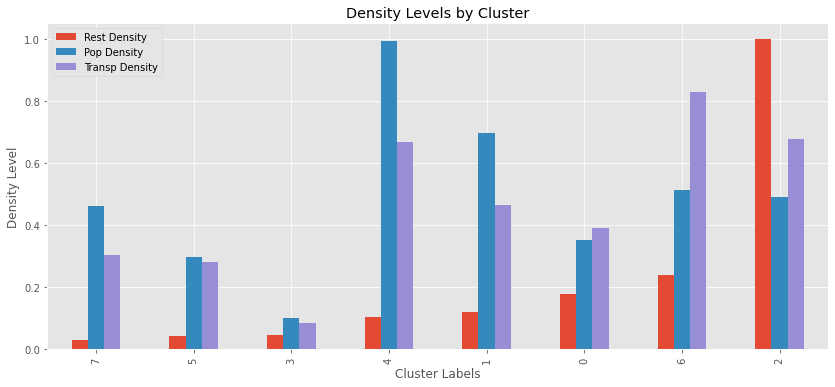

In [101]:
CABAvcl.loc[:,['Rest Density', 'Pop Density', 'Transp Density']].plot(kind='bar', figsize=(14, 6))

plt.xlabel('Cluster Labels') # add to x-label to the plot
plt.ylabel('Density Level') # add y-label to the plot
plt.title('Density Levels by Cluster') # add title to the plot

plt.show()

It is a good time to remember what this study is looking for:
1. In the first place, the **lowest** possible level of competition (red bars).
2. Secondly, the **highest** possible level of population density (blue bars).
3. Finally, in the third place, the **highest** possible level of transport density, or transportation access (purple bars).

Now, the exploration of each cluster in the listed order.

#### Cluster 7

This appear to be a cluster with **very little** competition, a medium level of population density, but on the lower side about how well connected it is.

In [102]:
CABAnorm[CABAnorm['Cluster Labels'] == 7].sort_values(['Pop Density'], ascending = False)

Cluster Labels      Neighbourhood  Rest Density  Pop Density  \
9                7             Flores      0.023907     0.570661   
22               7      Villa Urquiza      0.030152     0.496158   
3                7   Villa Del Parque      0.036248     0.478685   
10               7           Floresta      0.070801     0.476535   
25               7  Villa Gral. Mitre      0.018997     0.472117   
6                7   Villa Santa Rita      0.000000     0.453499   
31               7   Parque Chacabuco      0.032156     0.428264   
14               7    Velez Sarsfield      0.051334     0.425931   
33               7            Palermo      0.028514     0.415737   
18               7       Villa Lugano      0.008837     0.393226   

    Transp Density  
9         0.322543  
22        0.316645  
3         0.247408  
10        0.414649  
25        0.267992  
6         0.240487  
31        0.291241  
14        0.406932  
33        0.258719  
18        0.270423

#### Cluster 5

This appears to be a cluster with **very little** competition, againt, but with a low level of both population density and transportation access.

In [103]:
CABAnorm[CABAnorm['Cluster Labels'] == 5].sort_values(['Pop Density'], ascending = False)

Cluster Labels      Neighbourhood  Rest Density  Pop Density  \
7                5       Monte Castro      0.031266     0.367644   
15               5         Villa Luro      0.112013     0.363318   
26               5        Parque Chas      0.029649     0.362096   
36               5   Villa Pueyrredon      0.037305     0.342239   
46               5              Nuñez      0.111412     0.333817   
30               5  Parque Avellaneda      0.008679     0.317942   
29               5           Barracas      0.000000     0.317938   
37               5       Villa Devoto      0.070549     0.290345   
38               5            Liniers      0.028170     0.280788   
39               5          Versalles      0.058394     0.272328   
20               5           Saavedra      0.007416     0.248458   
47               5               Boca      0.089716     0.244513   
1                5           Paternal      0.018421     0.240815   
17               5          Mataderos      0.000000     0.236560   
32               5      Nueva Pompeya      0.024887     0.233766   

    Transp Density  
7         0.213713  
15        0.291970  
26        0.254888  
36        0.349399  
46        0.145219  
30        0.310651  
29        0.278137  
37        0.278834  
38        0.373602  
39        0.313244  
20        0.331642  
47        0.254504  
1         0.199249  
17        0.249342  
32        0.370188

#### Cluster 3

This small cluster appears to have **very little** competition, again, but a very low level of both population density and transportation access.

In [104]:
CABAnorm[CABAnorm['Cluster Labels'] == 3].sort_values(['Pop Density'], ascending = False)

Cluster Labels    Neighbourhood  Rest Density  Pop Density  Transp Density
27               3        Agronomia      0.096778     0.167467        0.107194
35               3    Villa Soldati      0.000000     0.129898        0.035689
34               3  Villa Riachuelo      0.009705     0.063931        0.166067
40               3    Puerto Madero      0.081484     0.041039        0.037140

#### Cluster 4

This is another small cluster offering **very little** competition, once more, but a **very high** level of population density and a **high** level of transportation access.

In [105]:
CABAnorm[CABAnorm['Cluster Labels'] == 4].sort_values(['Pop Density'], ascending = False)

Cluster Labels Neighbourhood  Rest Density  Pop Density  Transp Density
4                4       Almagro      0.162244     1.000000        0.548360
24               4     Balvanera      0.047297     0.983371        0.787807

Particularly, the neighbourhood of **Balvanera** seems to be the more adequate so far and, because of the densities shown, it will be difficult to find a better one.

#### Cluster 1

This cluster shows a **low** level of competition, a **high** level of population density and a medium level of transportation access.

In [106]:
CABAnorm[CABAnorm['Cluster Labels'] == 1].sort_values(['Pop Density'], ascending = False)

Cluster Labels  Neighbourhood  Rest Density  Pop Density  Transp Density
5                1      Caballito      0.035973     0.781526        0.441336
44               1       Recoleta      0.071523     0.759055        0.407734
12               1  San Cristobal      0.080394     0.720104        0.605802
23               1     Colegiales      0.161449     0.693311        0.351280
2                1   Villa Crespo      0.261268     0.684186        0.474720
13               1          Boedo      0.110171     0.538575        0.510046

#### Cluster 0

This cluster shows a **low** level of competition, combined with a medium to low level of both population density and transportation access.

In [107]:
CABAnorm[CABAnorm['Cluster Labels'] == 0].sort_values(['Pop Density'], ascending = False)

Cluster Labels     Neighbourhood  Rest Density  Pop Density  \
43               0          Belgrano      0.302962     0.463488   
21               0           Coghlan      0.224641     0.423397   
45               0            Retiro      0.227555     0.422125   
28               0     Villa Ortuzar      0.155103     0.333275   
16               0  Parque Patricios      0.120700     0.308366   
8                0        Villa Real      0.030788     0.279808   
0                0         Chacarita      0.184568     0.242984   

    Transp Density  
43        0.239862  
21        0.292878  
45        0.451064  
28        0.357146  
16        0.407661  
8         0.511280  
0         0.486219

#### Cluster 6

This small cluster shows a **low** level of competition, a medium of population density and **very high** transportation access.

In [108]:
CABAnorm[CABAnorm['Cluster Labels'] == 6].sort_values(['Pop Density'], ascending = False)

Cluster Labels Neighbourhood  Rest Density  Pop Density  Transp Density
11               6  Constitucion      0.136789     0.630225        1.000000
41               6     Monserrat      0.317602     0.539478        0.737278
42               6   San Nicolas      0.269171     0.367383        0.749116

#### Cluster 2

This small cluster simply is the neighbourhood of San Telmo. It shows a the highest level of competition, a medium of population density and **high** transportation access.

In [109]:
CABAnorm[CABAnorm['Cluster Labels'] == 2].sort_values(['Pop Density'], ascending = False)

Cluster Labels Neighbourhood  Rest Density  Pop Density  Transp Density
19               2     San Telmo           1.0     0.489562        0.678669

Map Showing the clusters, to visualize how the clusters ended up geographically distributed.

In [110]:
CABAfin = CABAcalc.copy()
CABAfin.insert(0, 'Cluster Labels', kmeans.labels_)

In [111]:
# Creation of the map.
Cluster_map = folium.Map(location=[g.latlng[0], g.latlng[1]], zoom_start=12)

In [112]:
# Setting of the color scheme for the clusters.
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add the markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CABAfin['Latitude'], 
                                  CABAfin['Longitude'], 
                                  CABAfin['Neighbourhood'], 
                                  CABAfin['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Cluster_map)

In [113]:
# Display of the map.
Cluster_map

## Discussion and Conclusion <a name="discussion"></a>

This division into eight clusters served as a filter, useful in realizing the general properties of the neighbourhoods in each of them. As seen, the level of competition is low in a number of them, but the other criteria fail. On the other extreme of the spectrum, when the seconday criteria (popupation and transport density) become both higher, the competition also increases. This left **Cluster** 4 as a promising candidate, with reasonably little competition and high values for the remaining features.
When inspected closely, Cluster 4 truly had the best combination of features, specially considering the neighbourhood of **Balvanera**. This presented very little competition, very high density population and high access to public transport, making it ideal in this study.

Therefore, **answering the problem question**, those entrepreneurs looking **for opening a restaurant in Buenos Aires** should do good use of this study and further research what other conditions offers the neighbourhood of **Balvanera**. 

Finally, a visualization of the selected neighbourhood.

In [114]:
# Creation of the map.
mapBalvanera = folium.Map(location=[CABAfin.loc[24, 'Latitude'], CABAfin.loc[24, 'Longitude']], zoom_start=15)
mapBalvanera.choropleth(
    geo_data=CABAgeo,
    data=pd.concat([pd.DataFrame(CABAcalc.Neighbourhood.str.upper()), \
                    CABAfin.loc[:, 'Rest Density']], axis=1, ignore_index=True) \
                    .rename(columns = {0:'Neighbourhood', 1:'Rest Density'}),
    columns=['Neighbourhood', 'Rest Density'],
    key_on='feature.properties.barrio',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Restaurant Density'
)

In [115]:
# Addition of the marker.
label = 'Selected: Balvanera'
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [CABAfin.loc[24, 'Latitude'], CABAfin.loc[24, 'Longitude']],
    radius=15,
    popup=label,
    color='white',
    fill=True,
    fill_color='white',
    fill_opacity=0.9,
    parse_html=False).add_to(mapBalvanera)

In [116]:
# Display of the map
mapBalvanera